# Make a Flamingo Euclid RR2 catalog/map

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import LSS_forward_model
from LSS_forward_model.cosmology import *
from LSS_forward_model.lensing import *
from LSS_forward_model.maps import *
from LSS_forward_model.halos import *
from LSS_forward_model.tsz import *
from LSS_forward_model.theory import *
import os
import pandas as pd
import numpy as np
import healpy as hp
from cosmology import Cosmology
import astropy.io.fits as fits
import copy
import glass
import frogress
from astropy.cosmology import wCDM

# Setup forward model - config

In [12]:
# Setup     ********************************
path_simulation = '/global/cfs/cdirs/m5099/Flamingo/'
# general settings ----------------------------------
nside_maps = 1024

# nuisance parameters ------------------------------
nuisance_parameters = dict()
nuisance_parameters['dz'] =  [0,0,0,0,0,0,0]
nuisance_parameters['dm'] =  [1,1,1,1,1,1,1]
nuisance_parameters['A_IA'] = 0.
nuisance_parameters['eta_IA'] = 0.
nuisance_parameters['bias_sc'] = [1,1,1,1,1,1,1]
nuisance_parameters['rot'] = 0


# Baryonification settings ------------------------------------------------
baryons = {
    "enabled": False,
    "max_z_halo_catalog": 1,
    "mass_cut": 13.,
    "do_tSZ": False,
    "base_params_path": "../Data/Baryonification_default_parameters.npy",
    "filename_new_params": "sys_baryo_0.npy",
    "values_to_update":  None, # or: {'Mc': 10**13,'theta_ej' : 4.} or draw_params_from_specs( {"M_c": (12.5, 15.5, "log10"),   "theta_ej": (3.0, 10.0, "lin"),    "eta": (-2.0, -0.1, "log10")} )
}

SC_corrections = np.load('../Data/SC_RR2_fit_nov6.npy',allow_pickle =True).item()



# Read cosmology & setup params

In [13]:
# Flamingo Cosmology ****************************************
sims_parameters = {'Omega_b': 0.0486	,
 'Omega_nu': 1.39 * 0.001,
 'Omega_m': 0.306	,
 'Omega_cdm': 0.25601,
 'h':  0.681,
 'w0': -1.0,
 'wa': 0.0,
 'As': 2.099e-09,
 'n_s': 0.967,
 'sigma_8': 0.807,
 'm_nu': 0.060,
 'n_nu': 1,
 'dBoxSize Mpc/h': 1000*0.681}



cosmo_bundle = make_cosmo_bundle(sims_parameters)
sims_parameters.update(nuisance_parameters)
    

z_edges = np.linspace(0,3.0,61)
d_edges = redshift_to_distance(z_edges,cosmo_bundle)*sims_parameters['h']

d_edges = np.hstack([d_edges,redshift_to_distance(np.arange(z_edges[-1],6.,0.12)[1:],cosmo_bundle)*sims_parameters['h']])
z_edges = np.hstack([z_edges,np.arange(z_edges[-1],6.,0.12)[1:]])
shells_info = make_shells_info_from_edges(z_edges, d_edges)



# setup n(z)

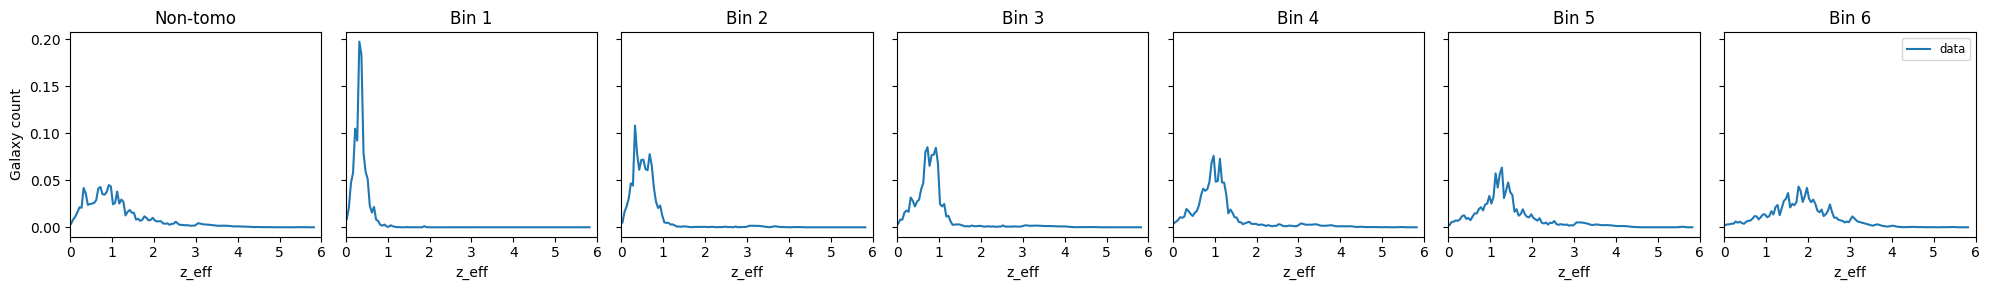

In [14]:
nz_RR2 = np.load('/global/cfs/cdirs/m5099/RR2/Reg2_SHE_tombins_unitweights_nz_SOMbin_C2020z_rebinned.npy',allow_pickle=True).item()

# -------------------------------------------------------
nz_shifted, shells, steps, zeff_glass, ngal_glass = apply_nz_shifts_and_build_shells(
    z_rebinned=nz_RR2['z_rebinned'],
    nz_all=nz_RR2['nz_rebinned'],
    dz_values=sims_parameters["dz"],
    shells_info=shells_info,
)

# Plot -----------------------------------------------------------------
fig, axes = plt.subplots(1, 7, figsize=(20, 3), sharey=True)
titles = ["Non-tomo"] + [f"Bin {i}" for i in range(1, 7)]
for i, ax in enumerate(axes):
    ax.plot(zeff_glass, ngal_glass[i], label="data")
    ax.set_xlim(0, 6)
    ax.set_title(titles[i])
    if i == 0: ax.set_ylabel("Galaxy count")
    ax.set_xlabel("z_eff")
axes[-1].legend(loc="upper right", fontsize="small")
plt.tight_layout(); plt.show()


# Baryonify original Flamingo (optional)

In [15]:
type_  = 'DMO_FIDUCIAL'
path = "/pscratch/sd/j/junzhez/flamingo/flamingo_reduced_tsz/{0}/lightcone0_shells_nside1024/".format(type_)
path_catalog = '/global/cfs/cdirs/m5099/Flamingo/data/L1000N1800_DMO_FIDUCIAL_fof_halo_cat_marco_2.fits'
dens_path = os.path.join(path_simulation, f"delta_b_{nside_maps}.npy")

baryons1 = copy.deepcopy(baryons)
baryons1["enabled"] = 'True'
bpar, sys = load_or_save_updated_params(path_simulation,baryons['base_params_path'],baryons['filename_new_params'],baryons['values_to_update'], overwrite = False)  


# load particle counts ------------------
n_particles = []
for i in range(len(z_edges)-1):
    try:
        m = h5.File(path+'shell_{0}.hdf5'.format(i))
        mass = np.array(m['TotalMass'])
        n_particles.append(mass)
    except:
        pass


# load catalog
halos_flamingo = load_Flamingo_halo_catalog(path_catalog,sims_parameters, cosmo_bundle, type_cat = 'fof',halo_catalog_log10mass_cut = baryons['mass_cut'], max_z_halo_catalog = baryons['max_z_halo_catalog'])

# baryonify Flamingo ------------------------
make_tsz_and_baryonified_density(
                path_simulation,
                sims_parameters,
                cosmo_bundle['cosmo_pyccl'],
                halos_flamingo,
                bpar,
                nside_maps,
                shells_info,
                dens_path,
                '',
                baryons['do_tSZ'],
                shells,
                cosmo_bundle['pars_camb'],
                baryons['mass_cut'],
                particles = n_particles
            )

density = np.load(dens_path,allow_pickle=True)
fields_baryo = compute_lensing_fields(density, shells, cosmo_bundle['pars_camb'], nside_maps, do_kappa=True, do_shear=True, do_IA=True)
fields_baryo['density'] = density


100.0% | [##########] | Progress: 84 / 84 | Time: 1min19s | ETA: --            

# load density shells and compute shear field

In [16]:
type_  = 'DMO_FIDUCIAL'
path = "/pscratch/sd/j/junzhez/flamingo/flamingo_reduced_tsz/{0}/lightcone0_shells_nside1024/".format(type_)

# load density -------------------------
# Assuming you start from redshift 0 and you go higher z
density = []
for i in range(len(z_edges)-1):
    try:
        m = h5.File(path+'shell_{0}.hdf5'.format(i))
        mass = np.array(m['TotalMass'])
        d = mass/np.mean(mass)-1.
        density.append(d)
    except:
        pass
density = np.array(density)


#add high redshift shells --------------
if len(shells)>len(density):
    missing_shells = []
    for i in range(len(density),len(shells)):
        missing_shells.append(shells[i])
    density_to_be_added = add_shells(cosmo_bundle['pars_camb'],nside_maps = nside_maps,missing_shells = missing_shells)
density = np.vstack([density,density_to_be_added])

# shear field ---------------------------
fields = compute_lensing_fields(density, shells, cosmo_bundle['pars_camb'], nside_maps, do_kappa=True, do_shear=True, do_IA=True)
fields['density'] = density

100.0% | [##########] | Progress: 84 / 84 | Time: 1min15s | ETA: --            

# Theory checks

100.0% | [##########] | Progress: 4000 / 4000 | Time: 3.1s | ETA: --           

/tmp/ipykernel_2245732/2265158576.py:27: RuntimeWarning: divide by zero encountered in divide
  ax.plot(Cls[tomo, :ell_max]/(Cgg[tomo, tomo, :ell_max] * (pix**2)))
/tmp/ipykernel_2245732/2265158576.py:29: RuntimeWarning: divide by zero encountered in divide
  ax.plot(Cls_baryo[tomo, :ell_max]/(Cgg[tomo, tomo, :ell_max] * (pix**2)))


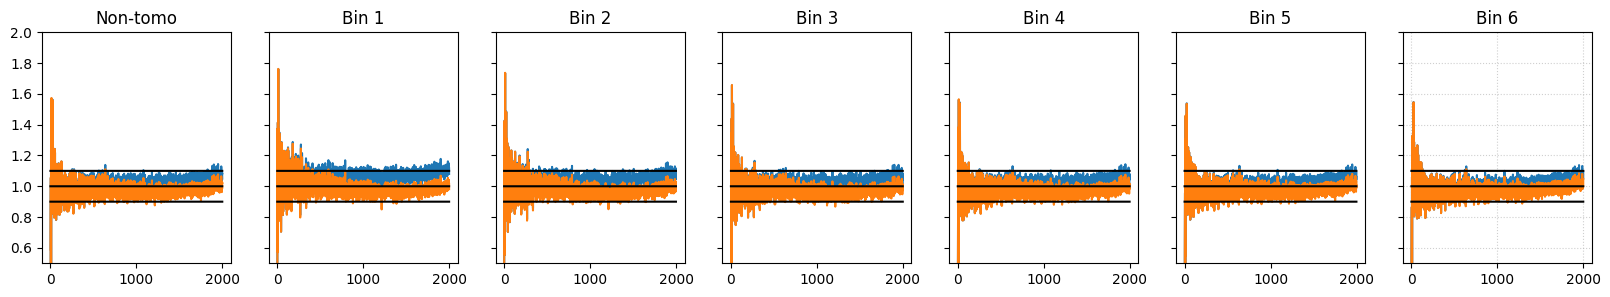

In [17]:
theory = LimberTheory(cosmo_bundle['pars_camb'], lmax=4000, nonlinear="mead")  # "euclidemu" | "mead" | "halofit"
theory.set_Wshear(np.vstack([nz_RR2['z_rebinned'],nz_shifted]).T)
Cgg = theory.cl_gg(nonlinear=True)


kappa_tomo = integrate_field(ngal_glass, fields["kappa"])
Cls = np.array([(hp.anafast(kappa_tomo[tomo,:])) for tomo in range(len(ngal_glass))])

try:
    kappa_tomo_baryo = integrate_field(ngal_glass, fields_baryo["kappa"])
    Cls_baryo = np.array([(hp.anafast(kappa_tomo_baryo[tomo,:])) for tomo in range(len(ngal_glass))])

except:
    pass


# choose a safe ℓ-range common to all arrays
ell_max = 2000
pix = hp.pixwin(nside_maps)[:ell_max]
ells = np.arange(ell_max)

mask_ell = ells >= 2  # avoid ℓ=0,1

fig, axes = plt.subplots(1, 7, figsize=(20, 3), sharey=True)
titles = ["Non-tomo"] + [f"Bin {i}" for i in range(1, 7)]
for tomo, ax in enumerate(axes):
    ax.plot(Cls[tomo, :ell_max]/(Cgg[tomo, tomo, :ell_max] * (pix**2)))
    try:
        ax.plot(Cls_baryo[tomo, :ell_max]/(Cgg[tomo, tomo, :ell_max] * (pix**2)))
    except:
        pass
    ax.plot(np.ones(ell_max),color = 'black')
    ax.plot(0.9*np.ones(ell_max),color = 'black')
    ax.plot(1.1*np.ones(ell_max),color = 'black')
    ax.set_ylim([0.5,2])
    ax.set_title(titles[tomo])

ax.grid(True, which="both", ls=":", alpha=0.6)


# Make mocks/maps

In [ ]:
path_data_cats = '/global/cfs/cdirs/m5099/RR2/Euclid_cats.npy'
cats_Euclid  = np.load(path_data_cats,allow_pickle=True).item()
maps_Gower_WL,_ = make_WL_sample(ngal_glass, zeff_glass, cosmo_bundle, sims_parameters, nside_maps, fields, cats_Euclid, SC_corrections = SC_corrections, do_catalog = False, include_SC = True)

In [1]:
1

1

# Extensive tests baryonification

In [46]:
#- how much baryonification am I loosing at z > 1.5? [not much, mostly at z<1]

In [18]:
types = ['HYDRO_FIDUCIAL','DMO_FIDUCIAL']
path_base = "/pscratch/sd/j/junzhez/flamingo/flamingo_reduced_tsz/" # '/global/cfs/cdirs/m5099/Flamingo/data/'

cls_dict = dict()
for type_ in types:

    path = path_base+"/{0}/lightcone0_shells_nside1024/".format(type_)

    # load density -------------------------
    # Assuming you start from redshift 0 and you go higher z
    density = []
    for i in range(len(z_edges)-1):
        try:
            m = h5.File(path+'shell_{0}.hdf5'.format(i))
            mass = np.array(m['TotalMass'])
            d = mass/np.mean(mass)-1.
            density.append(d)
        except:
            pass
    density = np.array(density)
    
    
    #add high redshift shells --------------
    if len(shells)>len(density):
        missing_shells = []
        for i in range(len(density),len(shells)):
            missing_shells.append(shells[i])
        density_to_be_added = add_shells(cosmo_bundle['pars_camb'],nside_maps = nside_maps,missing_shells = missing_shells)
    density = np.vstack([density,density_to_be_added])


    fields = compute_lensing_fields(density, shells, cosmo_bundle['pars_camb'], nside_maps, do_kappa=True, do_shear=False, do_IA=False)
    kappa_tomo = integrate_field(ngal_glass, fields["kappa"])
    cls_dict[type_]  = np.array([(hp.anafast(kappa_tomo[tomo,:])) for tomo in range(len(ngal_glass))])


100.0% | [##########] | Progress: 84 / 84 | Time: 5.8s | ETA: --               

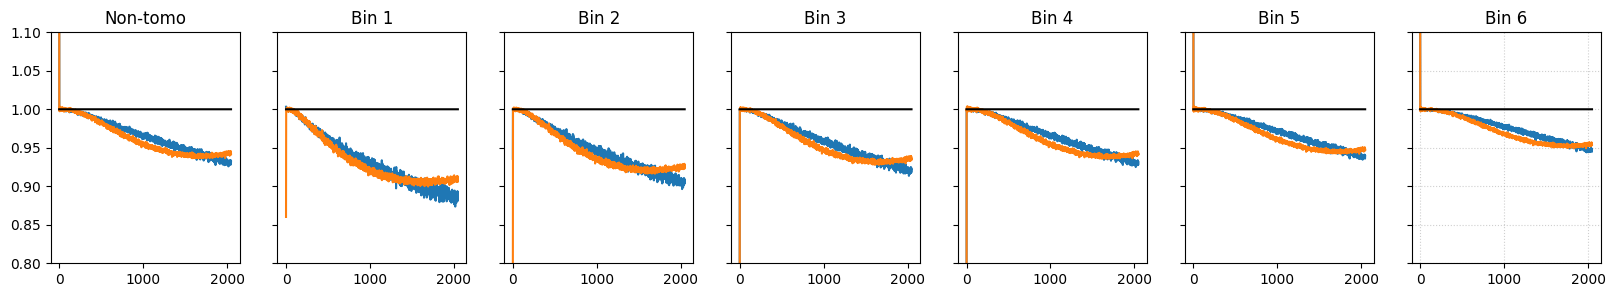

In [19]:
ratios = cls_dict['HYDRO_FIDUCIAL']/cls_dict['DMO_FIDUCIAL']

ell_max = 2048
fig, axes = plt.subplots(1, 7, figsize=(20, 3), sharey=True)
titles = ["Non-tomo"] + [f"Bin {i}" for i in range(1, 7)]
for tomo, ax in enumerate(axes):
    ax.plot(ratios[tomo,:ell_max])
    ax.plot(Cls_baryo[tomo, :ell_max]/Cls[tomo, :ell_max])
    ax.plot(np.ones(ell_max),color = 'black')
    ax.set_ylim([0.8,1.1])
    #ax.plot(0.9*np.ones(ell_max),color = 'black')
    #ax.plot(1.1*np.ones(ell_max),color = 'black')
    ax.set_title(titles[tomo])

ax.grid(True, which="both", ls=":", alpha=0.6)

In [6]:
path_simulation = '/global/cfs/cdirs/m5099/GowerSt2/Flamingo/'
nside_maps = 1024

# nuisance parameters ------------------------------
nuisance_parameters = dict()
nuisance_parameters['dz'] =  [0,0,0,0,0,0,0]
nuisance_parameters['dm'] =  [1,1,1,1,1,1,1]
nuisance_parameters['A_IA'] = 0.
nuisance_parameters['eta_IA'] = 0.
nuisance_parameters['bias_sc'] = [1,1,1,1,1,1,1]
nuisance_parameters['rot'] = 0



sims_parameters, cosmo_bundle = read_sims_params(path_simulation)
sims_parameters.update(nuisance_parameters)
    
shells_info = recover_shell_info(path_simulation+'/z_values.txt', max_z=49)

nz_RR2 = np.load('/global/cfs/cdirs/m5099/RR2/Reg2_SHE_tombins_unitweights_nz_SOMbin_C2020z_rebinned.npy',allow_pickle=True).item()

# -------------------------------------------------------
nz_shifted, shells, steps, zeff_glass, ngal_glass = apply_nz_shifts_and_build_shells(
    z_rebinned=nz_RR2['z_rebinned'],
    nz_all=nz_RR2['nz_rebinned'],
    dz_values=sims_parameters["dz"],
    shells_info=shells_info,
)



baryons = {
    "enabled": True,
    "max_z_halo_catalog": 1,
    "mass_cut": 13.,
    "do_tSZ": False,
    "base_params_path": "../Data/Baryonification_default_parameters.npy",
    "filename_new_params": "sys_baryo_0.npy",
    "values_to_update":  None, # or: {'Mc': 10**13,'theta_ej' : 4.} or draw_params_from_specs( {"M_c": (12.5, 15.5, "log10"),   "theta_ej": (3.0, 10.0, "lin"),    "eta": (-2.0, -0.1, "log10")} )
}

bpar, sys = load_or_save_updated_params(path_simulation,baryons['base_params_path'],baryons['filename_new_params'],baryons['values_to_update'], overwrite = False)  

density, label_baryonification = load_and_baryonify_gower_st_shells(
    path_simulation,
    sims_parameters,
    cosmo_bundle,
    baryons,
    nside_maps,
    shells_info,
    shells,
    overwrite_baryonified_shells = True)


fields_baryo = compute_lensing_fields(density, shells, cosmo_bundle['pars_camb'], nside_maps, do_kappa=True, do_shear=True, do_IA=True)
fields_baryo['density'] = density
kappa_tomo_baryo = integrate_field(ngal_glass, fields_baryo["kappa"])
Cls_baryo_myf = np.array([(hp.anafast(kappa_tomo_baryo[tomo,:])) for tomo in range(len(ngal_glass))])

# density field ---------------------
baryons = {
    "enabled": False,
    "max_z_halo_catalog": 1,
    "mass_cut": 13.,
    "do_tSZ": False,
    "base_params_path": "../Data/Baryonification_default_parameters.npy",
    "filename_new_params": "sys_baryo_0.npy",
    "values_to_update":  None, # or: {'Mc': 10**13,'theta_ej' : 4.} or draw_params_from_specs( {"M_c": (12.5, 15.5, "log10"),   "theta_ej": (3.0, 10.0, "lin"),    "eta": (-2.0, -0.1, "log10")} )
}
density_dmo, label_baryonification = load_and_baryonify_gower_st_shells(
    path_simulation,
    sims_parameters,
    cosmo_bundle,
    baryons,
    nside_maps,
    shells_info,
    shells)

# shear field ---------------------------
fields = compute_lensing_fields(density_dmo, shells, cosmo_bundle['pars_camb'], nside_maps, do_kappa=True, do_shear=True, do_IA=True)
fields['density'] = density_dmo

kappa_tomo = integrate_field(ngal_glass, fields["kappa"])
Cls_myf = np.array([(hp.anafast(kappa_tomo[tomo,:])) for tomo in range(len(ngal_glass))])


/global/homes/m/mgatti/.conda/envs/pyccl_env/lib/python3.11/site-packages/LSS_forward_model-0.1-py3.11.egg/LSS_forward_model/halos.py:496: RuntimeWarning: invalid value encountered in log10


baryonifying shells --
  1.0% | [..........] | Progress: 1 / 100 | Time: 0.0s | ETA: 0.0s             

/global/homes/m/mgatti/.conda/envs/pyccl_env/lib/python3.11/site-packages/BaryonForge/Profiles/Base.py:243: UserWarning: WARNING: Profile is zero/negative in some places.Likely a convolution artifact for objects smaller than the pixel scale
  warnings.warn("WARNING: Profile is zero/negative in some places."
/global/homes/m/mgatti/.conda/envs/pyccl_env/lib/python3.11/site-packages/BaryonForge/Profiles/BaryonCorrection.py:691: RuntimeWarning: divide by zero encountered in log
  M_f[M_i] = np.exp( interpolate.PchipInterpolator(np.log(r_int)[Mask], np.log(M_enc[M_i])[Mask], extrapolate = False)(lnr) )
/global/homes/m/mgatti/.conda/envs/pyccl_env/lib/python3.11/site-packages/BaryonForge/Profiles/BaryonCorrection.py:691: RuntimeWarning: invalid value encountered in log
  M_f[M_i] = np.exp( interpolate.PchipInterpolator(np.log(r_int)[Mask], np.log(M_enc[M_i])[Mask], extrapolate = False)(lnr) )
/global/homes/m/mgatti/.conda/envs/pyccl_env/lib/python3.11/site-packages/BaryonForge/Profiles/Schne

  2.0% | [..........] | Progress: 2 / 100 | Time: 18.3s | ETA: 14min59s        

/global/homes/m/mgatti/.conda/envs/pyccl_env/lib/python3.11/site-packages/BaryonForge/Profiles/Base.py:243: UserWarning: WARNING: Profile is zero/negative in some places.Likely a convolution artifact for objects smaller than the pixel scale
  warnings.warn("WARNING: Profile is zero/negative in some places."
/global/homes/m/mgatti/.conda/envs/pyccl_env/lib/python3.11/site-packages/BaryonForge/Profiles/Schneider19.py:773: UserWarning: Decrease integral lower limit, r_min_int (1e-08) < minimum radius (8.333333333333334e-10)
  warnings.warn(f"Decrease integral lower limit, r_min_int ({self.r_min_int}) < minimum radius ({np.min(r)})", UserWarning)
/global/homes/m/mgatti/.conda/envs/pyccl_env/lib/python3.11/site-packages/BaryonForge/Profiles/Schneider19.py:775: UserWarning: Increase integral upper limit, r_max_int (100000.0) < maximum radius (1200000.0)
  warnings.warn(f"Increase integral upper limit, r_max_int ({self.r_max_int}) < maximum radius ({np.max(r)})", UserWarning)
Baryonifying mat

  3.0% | [..........] | Progress: 3 / 100 | Time: 40.4s | ETA: 21min46s        

Baryonifying matter: 100%|██████████| 851/851 [00:11<00:00, 74.17it/s]


  4.0% | [..........] | Progress: 4 / 100 | Time: 1min6s | ETA: 26min14s       

Baryonifying matter: 100%|██████████| 2248/2248 [00:16<00:00, 135.82it/s]


  5.0% | [..........] | Progress: 5 / 100 | Time: 1min35s | ETA: 29min56s      

Baryonifying matter: 100%|██████████| 3494/3494 [00:15<00:00, 222.11it/s]


  6.0% | [..........] | Progress: 6 / 100 | Time: 2min3s | ETA: 32min12s       

Baryonifying matter: 100%|██████████| 5292/5292 [00:16<00:00, 318.14it/s]


  7.0% | [..........] | Progress: 7 / 100 | Time: 2min33s | ETA: 33min54s      

Baryonifying matter: 100%|██████████| 7252/7252 [00:17<00:00, 406.99it/s]


  8.0% | [..........] | Progress: 8 / 100 | Time: 3min4s | ETA: 35min13s       

Baryonifying matter: 100%|██████████| 10202/10202 [00:19<00:00, 519.64it/s]


  9.0% | [..........] | Progress: 9 / 100 | Time: 3min36s | ETA: 36min23s      

Baryonifying matter: 100%|██████████| 14204/14204 [00:22<00:00, 622.83it/s]


 10.0% | [#.........] | Progress: 10 / 100 | Time: 4min12s | ETA: 37min51s     

Baryonifying matter: 100%|██████████| 17442/17442 [00:22<00:00, 777.66it/s]


 11.0% | [#.........] | Progress: 11 / 100 | Time: 4min47s | ETA: 38min46s     

Baryonifying matter: 100%|██████████| 22222/22222 [00:25<00:00, 860.53it/s]


 12.0% | [#.........] | Progress: 12 / 100 | Time: 5min27s | ETA: 39min57s     

Baryonifying matter: 100%|██████████| 25842/25842 [00:26<00:00, 974.55it/s] 


 13.0% | [#.........] | Progress: 13 / 100 | Time: 6min7s | ETA: 40min53s      

Baryonifying matter: 100%|██████████| 30718/30718 [00:28<00:00, 1060.01it/s]


 14.0% | [#.........] | Progress: 14 / 100 | Time: 6min50s | ETA: 41min58s     

Baryonifying matter: 100%|██████████| 36229/36229 [00:31<00:00, 1159.95it/s]


 15.0% | [#.........] | Progress: 15 / 100 | Time: 7min34s | ETA: 42min55s     

Baryonifying matter: 100%|██████████| 42543/42543 [00:33<00:00, 1276.10it/s]


 16.0% | [#.........] | Progress: 16 / 100 | Time: 8min20s | ETA: 43min46s     

Baryonifying matter: 100%|██████████| 49430/49430 [00:36<00:00, 1336.23it/s]


 17.0% | [#.........] | Progress: 17 / 100 | Time: 9min11s | ETA: 44min49s     

Baryonifying matter: 100%|██████████| 57423/57423 [00:40<00:00, 1415.12it/s]


 18.0% | [#.........] | Progress: 18 / 100 | Time: 10min5s | ETA: 45min58s     

Baryonifying matter: 100%|██████████| 67490/67490 [00:45<00:00, 1479.68it/s]


 19.0% | [#.........] | Progress: 19 / 100 | Time: 11min6s | ETA: 47min17s     

Baryonifying matter: 100%|██████████| 76061/76061 [00:48<00:00, 1566.29it/s]


 20.0% | [##........] | Progress: 20 / 100 | Time: 12min7s | ETA: 48min27s     

Baryonifying matter: 100%|██████████| 86330/86330 [00:52<00:00, 1646.40it/s]


 21.0% | [##........] | Progress: 21 / 100 | Time: 13min14s | ETA: 49min47s    

Baryonifying matter: 100%|██████████| 95859/95859 [00:56<00:00, 1710.19it/s]


 22.0% | [##........] | Progress: 22 / 100 | Time: 14min24s | ETA: 51min4s     

Baryonifying matter: 100%|██████████| 104545/104545 [00:58<00:00, 1777.98it/s]


 23.0% | [##........] | Progress: 23 / 100 | Time: 15min37s | ETA: 52min16s    

Baryonifying matter: 100%|██████████| 118948/118948 [01:00<00:00, 1955.48it/s]


 24.0% | [##........] | Progress: 24 / 100 | Time: 16min52s | ETA: 53min23s    

Baryonifying matter: 100%|██████████| 131345/131345 [01:05<00:00, 1999.68it/s]


 25.0% | [##........] | Progress: 25 / 100 | Time: 18min13s | ETA: 54min39s    

Baryonifying matter: 100%|██████████| 146600/146600 [01:12<00:00, 2025.84it/s]


 26.0% | [##........] | Progress: 26 / 100 | Time: 19min40s | ETA: 55min58s    

Baryonifying matter: 100%|██████████| 159175/159175 [01:19<00:00, 2012.60it/s]


 27.0% | [##........] | Progress: 27 / 100 | Time: 21min11s | ETA: 57min17s    

Baryonifying matter: 100%|██████████| 173621/173621 [01:25<00:00, 2029.11it/s]


 28.0% | [##........] | Progress: 28 / 100 | Time: 22min51s | ETA: 58min45s    

Baryonifying matter: 100%|██████████| 193755/193755 [01:33<00:00, 2075.24it/s]


 29.0% | [##........] | Progress: 29 / 100 | Time: 24min38s | ETA: 1h0min20s   

Baryonifying matter: 100%|██████████| 213144/213144 [01:38<00:00, 2161.73it/s]


 30.0% | [###.......] | Progress: 30 / 100 | Time: 26min31s | ETA: 1h1min53s   

Baryonifying matter: 100%|██████████| 230355/230355 [01:44<00:00, 2212.76it/s]


 31.0% | [###.......] | Progress: 31 / 100 | Time: 28min28s | ETA: 1h3min22s   

Baryonifying matter: 100%|██████████| 268055/268055 [02:05<00:00, 2140.19it/s]


 33.0% | [###.......] | Progress: 33 / 100 | Time: 32min59s | ETA: 1h6min57s   

Baryonifying matter: 100%|██████████| 287477/287477 [02:14<00:00, 2138.47it/s]


 34.0% | [###.......] | Progress: 34 / 100 | Time: 35min28s | ETA: 1h8min51s   

Baryonifying matter: 100%|██████████| 311540/311540 [02:20<00:00, 2219.39it/s]


 35.0% | [###.......] | Progress: 35 / 100 | Time: 38min3s | ETA: 1h10min40s   

Baryonifying matter: 100%|██████████| 338171/338171 [02:30<00:00, 2244.07it/s]


 36.0% | [###.......] | Progress: 36 / 100 | Time: 40min49s | ETA: 1h12min34s  

Baryonifying matter: 100%|██████████| 359326/359326 [02:36<00:00, 2292.38it/s]


 37.0% | [###.......] | Progress: 37 / 100 | Time: 43min41s | ETA: 1h14min23s  

Baryonifying matter: 100%|██████████| 391035/391035 [02:51<00:00, 2282.27it/s]


 38.0% | [###.......] | Progress: 38 / 100 | Time: 46min49s | ETA: 1h16min23s  

Baryonifying matter: 100%|██████████| 420792/420792 [02:54<00:00, 2408.20it/s]


 39.0% | [###.......] | Progress: 39 / 100 | Time: 49min58s | ETA: 1h18min8s   

Baryonifying matter: 100%|██████████| 451779/451779 [03:12<00:00, 2343.50it/s]


 40.0% | [####......] | Progress: 40 / 100 | Time: 53min24s | ETA: 1h20min7s   

Baryonifying matter: 100%|██████████| 480061/480061 [03:06<00:00, 2578.60it/s]


 41.0% | [####......] | Progress: 41 / 100 | Time: 56min43s | ETA: 1h21min37s  

Baryonifying matter: 100%|██████████| 505042/505042 [03:12<00:00, 2627.74it/s]


 42.0% | [####......] | Progress: 42 / 100 | Time: 1h0min8s | ETA: 1h23min2s   

Baryonifying matter: 100%|██████████| 537702/537702 [03:22<00:00, 2656.71it/s]


 43.0% | [####......] | Progress: 43 / 100 | Time: 1h3min43s | ETA: 1h24min28s 

Baryonifying matter: 100%|██████████| 570835/570835 [03:34<00:00, 2660.75it/s]


 44.0% | [####......] | Progress: 44 / 100 | Time: 1h7min30s | ETA: 1h25min55s 

Baryonifying matter: 100%|██████████| 609328/609328 [03:46<00:00, 2695.59it/s]


 45.0% | [####......] | Progress: 45 / 100 | Time: 1h11min32s | ETA: 1h27min26s

Baryonifying matter: 100%|██████████| 651986/651986 [04:02<00:00, 2692.31it/s]


 46.0% | [####......] | Progress: 46 / 100 | Time: 1h15min49s | ETA: 1h28min60s

Baryonifying matter: 100%|██████████| 682787/682787 [04:10<00:00, 2721.81it/s]


 47.0% | [####......] | Progress: 47 / 100 | Time: 1h20min19s | ETA: 1h30min34s

Baryonifying matter: 100%|██████████| 720228/720228 [04:21<00:00, 2752.18it/s]


 48.0% | [####......] | Progress: 48 / 100 | Time: 1h24min55s | ETA: 1h31min60s

Baryonifying matter: 100%|██████████| 764839/764839 [04:42<00:00, 2708.21it/s]


 49.0% | [####......] | Progress: 49 / 100 | Time: 1h29min50s | ETA: 1h33min30s

Baryonifying matter: 100%|██████████| 799490/799490 [05:03<00:00, 2632.89it/s]


 50.0% | [#####.....] | Progress: 50 / 100 | Time: 1h35min8s | ETA: 1h35min8s  

Baryonifying matter: 100%|██████████| 845494/845494 [05:06<00:00, 2755.49it/s]


 51.0% | [#####.....] | Progress: 51 / 100 | Time: 1h40min28s | ETA: 1h36min31s

Baryonifying matter: 100%|██████████| 883542/883542 [05:37<00:00, 2621.74it/s]


 52.0% | [#####.....] | Progress: 52 / 100 | Time: 1h46min19s | ETA: 1h38min8s 

Baryonifying matter: 100%|██████████| 938564/938564 [05:53<00:00, 2652.45it/s]


 53.0% | [#####.....] | Progress: 53 / 100 | Time: 1h52min27s | ETA: 1h39min43s

Baryonifying matter: 100%|██████████| 978779/978779 [06:17<00:00, 2589.52it/s]


 54.0% | [#####.....] | Progress: 54 / 100 | Time: 1h58min58s | ETA: 1h41min21s

Baryonifying matter: 100%|██████████| 1025866/1025866 [06:23<00:00, 2676.92it/s]


 55.0% | [#####.....] | Progress: 55 / 100 | Time: 2h5min38s | ETA: 1h42min47s 

Baryonifying matter: 100%|██████████| 1071559/1071559 [06:51<00:00, 2601.21it/s]


 56.0% | [#####.....] | Progress: 56 / 100 | Time: 2h12min45s | ETA: 1h44min18s

Baryonifying matter: 100%|██████████| 1106255/1106255 [06:57<00:00, 2652.42it/s]


 57.0% | [#####.....] | Progress: 57 / 100 | Time: 2h19min57s | ETA: 1h45min35s

Baryonifying matter: 100%|██████████| 1160460/1160460 [07:06<00:00, 2720.17it/s]


 58.0% | [#####.....] | Progress: 58 / 100 | Time: 2h27min17s | ETA: 1h46min39s

Baryonifying matter: 100%|██████████| 1903/1903 [00:00<00:00, 2296.66it/s]


 59.0% | [#####.....] | Progress: 59 / 100 | Time: 2h27min33s | ETA: 1h42min32s

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.35s/it]


 60.0% | [######....] | Progress: 60 / 100 | Time: 2h27min43s | ETA: 1h38min29s

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.36s/it]


 61.0% | [######....] | Progress: 61 / 100 | Time: 2h27min55s | ETA: 1h34min34s

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.28s/it]


 62.0% | [######....] | Progress: 62 / 100 | Time: 2h28min5s | ETA: 1h30min46s 

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.23s/it]


 63.0% | [######....] | Progress: 63 / 100 | Time: 2h28min15s | ETA: 1h27min4s 

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.18s/it]


 64.0% | [######....] | Progress: 64 / 100 | Time: 2h28min27s | ETA: 1h23min30s

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.24s/it]


 65.0% | [######....] | Progress: 65 / 100 | Time: 2h28min38s | ETA: 1h20min2s 

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.25s/it]


 66.0% | [######....] | Progress: 66 / 100 | Time: 2h28min50s | ETA: 1h16min40s

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.29s/it]


 67.0% | [######....] | Progress: 67 / 100 | Time: 2h29min2s | ETA: 1h13min24s 

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.24s/it]


 68.0% | [######....] | Progress: 68 / 100 | Time: 2h29min13s | ETA: 1h10min13s

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.27s/it]


 69.0% | [######....] | Progress: 69 / 100 | Time: 2h29min25s | ETA: 1h7min8s  

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.19s/it]


 70.0% | [#######...] | Progress: 70 / 100 | Time: 2h29min37s | ETA: 1h4min7s  

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.24s/it]


 71.0% | [#######...] | Progress: 71 / 100 | Time: 2h30min15s | ETA: 1h1min22s 

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.25s/it]


 72.0% | [#######...] | Progress: 72 / 100 | Time: 2h30min27s | ETA: 58min31s  

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.22s/it]


 73.0% | [#######...] | Progress: 73 / 100 | Time: 2h30min41s | ETA: 55min44s  

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.27s/it]


 74.0% | [#######...] | Progress: 74 / 100 | Time: 2h30min52s | ETA: 53min1s   

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.23s/it]


 75.0% | [#######...] | Progress: 75 / 100 | Time: 2h31min3s | ETA: 50min21s   

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.21s/it]


 76.0% | [#######...] | Progress: 76 / 100 | Time: 2h31min14s | ETA: 47min46s  

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.21s/it]


 77.0% | [#######...] | Progress: 77 / 100 | Time: 2h31min26s | ETA: 45min14s  

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.19s/it]


 78.0% | [#######...] | Progress: 78 / 100 | Time: 2h31min37s | ETA: 42min46s  

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.22s/it]


 79.0% | [#######...] | Progress: 79 / 100 | Time: 2h31min48s | ETA: 40min21s  

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.23s/it]


 80.0% | [########..] | Progress: 80 / 100 | Time: 2h31min59s | ETA: 37min60s  

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.21s/it]


 81.0% | [########..] | Progress: 81 / 100 | Time: 2h32min11s | ETA: 35min42s  

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.22s/it]


 82.0% | [########..] | Progress: 82 / 100 | Time: 2h32min23s | ETA: 33min27s  

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.18s/it]


 83.0% | [########..] | Progress: 83 / 100 | Time: 2h32min34s | ETA: 31min15s  

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.21s/it]


 84.0% | [########..] | Progress: 84 / 100 | Time: 2h32min46s | ETA: 29min6s   

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.18s/it]


 85.0% | [########..] | Progress: 85 / 100 | Time: 2h32min58s | ETA: 26min60s  

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.23s/it]


 86.0% | [########..] | Progress: 86 / 100 | Time: 2h33min9s | ETA: 24min56s   

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.28s/it]


 87.0% | [########..] | Progress: 87 / 100 | Time: 2h33min20s | ETA: 22min55s  

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.25s/it]


 88.0% | [########..] | Progress: 88 / 100 | Time: 2h33min31s | ETA: 20min56s  

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.23s/it]


 89.0% | [########..] | Progress: 89 / 100 | Time: 2h33min42s | ETA: 18min60s  

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.16s/it]


 90.0% | [#########.] | Progress: 90 / 100 | Time: 2h33min53s | ETA: 17min6s   

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.21s/it]


 91.0% | [#########.] | Progress: 91 / 100 | Time: 2h34min5s | ETA: 15min14s   

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.23s/it]


 92.0% | [#########.] | Progress: 92 / 100 | Time: 2h34min15s | ETA: 13min25s  

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.24s/it]


 93.0% | [#########.] | Progress: 93 / 100 | Time: 2h34min26s | ETA: 11min37s  

Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.22s/it]


 94.0% | [#########.] | Progress: 94 / 100 | Time: 2h34min36s | ETA: 9min52s   

/global/homes/m/mgatti/.conda/envs/pyccl_env/lib/python3.11/site-packages/BaryonForge/Profiles/BaryonCorrection.py:271: UserWarning: Mass profile of log10(M) = 12.275862068965518 is nearly constant over radius. Or it is broken. Less than 5 datapoints are usable.
  warnings.warn(warn_text, UserWarning)
/global/homes/m/mgatti/.conda/envs/pyccl_env/lib/python3.11/site-packages/BaryonForge/Profiles/BaryonCorrection.py:304: UserWarning: Displacement function for halo with log10(M) = 12.275862068965518 failed to compute.Defaulting to d = 0. If using convolutions, consider changing the fft precision params in the CCL profile: padding_lo_fftlog, padding_hi_fftlog, or n_per_decade
  warnings.warn(warn_text, UserWarning)
Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.24s/it]


 95.0% | [#########.] | Progress: 95 / 100 | Time: 2h34min45s | ETA: 8min9s    

/global/homes/m/mgatti/.conda/envs/pyccl_env/lib/python3.11/site-packages/BaryonForge/Profiles/BaryonCorrection.py:271: UserWarning: Mass profile of log10(M) = 12.137931034482758 is nearly constant over radius. Or it is broken. Less than 5 datapoints are usable.
  warnings.warn(warn_text, UserWarning)
/global/homes/m/mgatti/.conda/envs/pyccl_env/lib/python3.11/site-packages/BaryonForge/Profiles/BaryonCorrection.py:304: UserWarning: Displacement function for halo with log10(M) = 12.137931034482758 failed to compute.Defaulting to d = 0. If using convolutions, consider changing the fft precision params in the CCL profile: padding_lo_fftlog, padding_hi_fftlog, or n_per_decade
  warnings.warn(warn_text, UserWarning)
/global/homes/m/mgatti/.conda/envs/pyccl_env/lib/python3.11/site-packages/BaryonForge/Profiles/BaryonCorrection.py:271: UserWarning: Mass profile of log10(M) = 12.0 is nearly constant over radius. Or it is broken. Less than 5 datapoints are usable.
  warnings.warn(warn_text, Use

generate step  6.0
 96.0% | [#########.] | Progress: 96 / 100 | Time: 2h34min50s | ETA: 6min27s   


Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.23s/it]

generate step  5.0
 97.0% | [#########.] | Progress: 97 / 100 | Time: 2h34min54s | ETA: 4min47s   


Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.20s/it]

generate step  4.0
 98.0% | [#########.] | Progress: 98 / 100 | Time: 2h34min58s | ETA: 3min10s   


Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.25s/it]

generate step  3.0
 99.0% | [#########.] | Progress: 99 / 100 | Time: 2h35min3s | ETA: 1min34s    


Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.23s/it]

generate step  2.0
100.0% | [##########] | Progress: 100 / 100 | Time: 2h35min7s | ETA: 0.0s      


/global/homes/m/mgatti/.conda/envs/pyccl_env/lib/python3.11/site-packages/BaryonForge/Profiles/BaryonCorrection.py:271: UserWarning: Mass profile of log10(M) = 12.413793103448276 is nearly constant over radius. Or it is broken. Less than 5 datapoints are usable.
  warnings.warn(warn_text, UserWarning)
/global/homes/m/mgatti/.conda/envs/pyccl_env/lib/python3.11/site-packages/BaryonForge/Profiles/BaryonCorrection.py:304: UserWarning: Displacement function for halo with log10(M) = 12.413793103448276 failed to compute.Defaulting to d = 0. If using convolutions, consider changing the fft precision params in the CCL profile: padding_lo_fftlog, padding_hi_fftlog, or n_per_decade
  warnings.warn(warn_text, UserWarning)
Building Table: 100%|██████████| 2/2 [00:04<00:00,  2.18s/it]

generate step  1.0
100.0% | [##########] | Progress: 100 / 100 | Time: 2h35min12s | ETA: --       

100.0% | [##########] | Progress: 100 / 100 | Time: 1min29s | ETA: --          

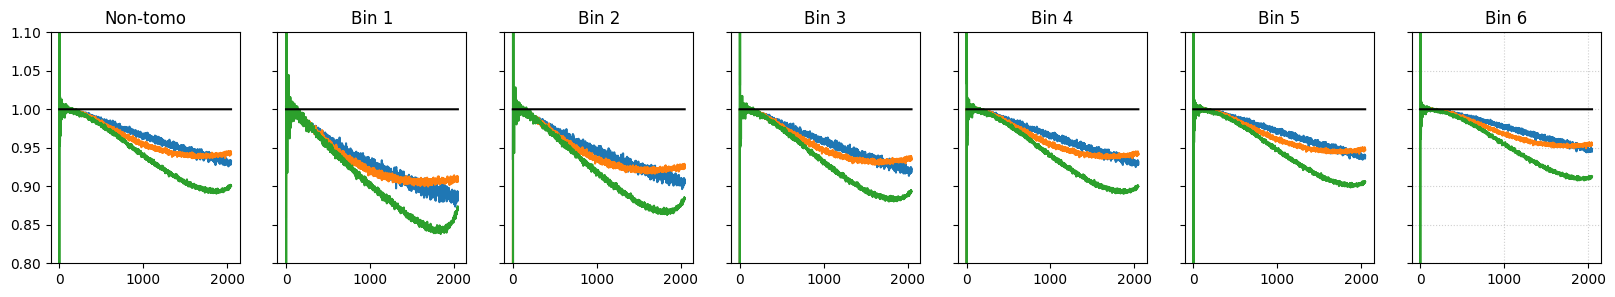

In [21]:
#ratios = cls_dict['HYDRO_FIDUCIAL']/cls_dict['DMO_FIDUCIAL']

ell_max = 2048
fig, axes = plt.subplots(1, 7, figsize=(20, 3), sharey=True)
titles = ["Non-tomo"] + [f"Bin {i}" for i in range(1, 7)]
for tomo, ax in enumerate(axes):
    ax.plot(ratios[tomo,:ell_max])
    ax.plot(Cls_baryo[tomo, :ell_max]/Cls[tomo, :ell_max])
    ax.plot(Cls_baryo_myf[tomo, :ell_max]/Cls_myf[tomo, :ell_max])
    ax.plot(np.ones(ell_max),color = 'black')
    ax.set_ylim([0.8,1.1])
    #ax.plot(0.9*np.ones(ell_max),color = 'black')
    #ax.plot(1.1*np.ones(ell_max),color = 'black')
    ax.set_title(titles[tomo])

ax.grid(True, which="both", ls=":", alpha=0.6)